Bartoś Edyta, Marcin Grelewicz,
LSTM generating poems
As inspiration we used: https://medium.com/predict/creating-a-poem-writer-ai-using-keras-and-tensorflow-16eac157cba6

Import bibliotek



In [2]:
import keras
import tensorflow as tf
from sklearn import model_selection
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Tokenizing

In [4]:
# with keras preprocessing we vectorize our words
tokenizer = Tokenizer()

# load data
data = open('/content/drive/MyDrive/ai_poeta/poems.txt', encoding="utf8").read()

print(tokenizer)

In [ ]:
#print(data)

In [5]:
#we lowercase and we call split method to treat sentence as a sequence
text = data.lower().split("\n")

In [6]:
print(text)

['fishy business', "man's got bigger fish ", 'to fry,', 'leaving the smaller fish ', 'to die,', 'still always wondering', 'sadness, why.', "if livin's easy,", "dying's an escape.", 'if being normal is easy,', 'put on the cape.', 'if being fat is easy,', 'shed all the shape.', 'if speaking is easy,', 'lay down the tape.', '', 'the one who was meant to be-', '', 'when i became we', 'nothing seemed difficult ', 'the world was indeed made of rainbows', 'of unicorns and extra crispy french fries', 'you made me complete', 'yet somehow the darkness never left', 'for the wounds had never healed', 'grey hid behind the curtain of colors', 'wanting to crush the horn of hope', 'i wanted to be me again', 'for the inverted m was never meant to be.', 'you took my heart and put it right', 'it was but my mind dwelling on the sorrows of past', 'my broken teeth, my swollen soul', 'fight had already boarded the flight', 'the one overbooked with my emotions', 'it was never supposed to fly again', 'yet you 

In [7]:
tokenizer.fit_on_texts(text)
'''The fit_on_texts method takes one sentence at a time, converts that sentence 
into the number sequence of each word from the dictionary and gives you back the
 final list of sequence.'''

total_words = len(tokenizer.word_index) + 1 # to avoid oov token
'''total number of words and add the length + 1 just to include a word tag which 
indicates if the new word coming in during testing is in the dictionary or not.'''

print(total_words)

1674


In [8]:
tokenized_text = [] #input vector which we feed the network
'''The for loop goes sequence by sequence(line by line) and generates new n-gram
 sequences and appends them in our training data.'''
for line in text:
	token_list = tokenizer.texts_to_sequences([line])[0] #give text of the sequences for the current line
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		tokenized_text.append(n_gram_sequence)

In [9]:
# pad sequences 
max_sequence_len = max([len(item) for item in tokenized_text])
tokenized_text = np.array(pad_sequences(tokenized_text, maxlen=max_sequence_len, padding='pre'))

In [10]:
# create X and y
X, y = tokenized_text[:,:-1],tokenized_text[:,-1]
print(X.shape, y.shape)
#X-> beginning of the list
#y-> end of the list

(3866, 11) (3866,)


In [11]:
'''convert targets to categorical y's i.e one hot encode them and treat the
 total number of words in the dictionary as the total number of classes.'''
y = tensorflow.keras.utils.to_categorical(y, num_classes=total_words)

In [12]:
print(X.shape, y.shape)

(3866, 11) (3866, 1674)


In [13]:
from sklearn.model_selection import train_test_split
# split into train test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3092, 11) (774, 11) (3092, 1674) (774, 1674)


Keras Tuner

In [16]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 3.6MB/s 


In [17]:
import kerastuner

In [18]:
hp = kerastuner.HyperParameters()

In [19]:
def build_model(hp):
  model = Sequential()
  model.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
  model.add(Bidirectional(LSTM(150, return_sequences = True)))
  model.add(Dropout(0.2))
  model.add(LSTM(100))
  #model.add(Bidirectional(LSTM(10, return_sequences = True)))
  #model.add(Dropout(0.1))
  #model.add(LSTM(10))
  '''model.add(Dense(
      hp.Int('hidden units',
            min_value=50,
            max_value = 200,
            step = 50),
      activation = 'relu'))'''
  model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
  model.add(Dense(total_words, activation='softmax'))

  model.compile(
    #optimizer=keras.optimizers.SGD(),
    optimizer='adam',
    #loss='sparse_categorical_crossentropy',
    loss='categorical_crossentropy',
    metrics=['accuracy'])
  return model

Random Search

In [20]:
from kerastuner.tuners import RandomSearch

In [21]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=4,
    executions_per_trial=1,
    directory='experiments',
    project_name='test')

In [22]:
tuner.search_space_summary()

Search space summary
Default search space size: 0


In [23]:
history = tuner.search(x = X_train, y = y_train, validation_data=(X_test, y_test), epochs = 200)

Trial 1 Complete [00h 24m 20s]
val_accuracy: 0.08914728462696075

Best val_accuracy So Far: 0.08914728462696075
Total elapsed time: 00h 24m 20s
INFO:tensorflow:Oracle triggered exit


In [24]:
tuner.get_best_models(num_models=2)

In [25]:
tuner.results_summary()

Results summary
Results in experiments/test
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
default configuration
Score: 0.08914728462696075


BayesianOptimization

In [26]:
def build_model(hp):
  model = Sequential()
  model.add(Embedding(total_words, 10, input_length=max_sequence_len-1))
  '''the model will take as input an integer matrix of size (batch, input_length). 
  the largest integer (i.e. word index) in the input should be
  no larger than 999 (vocabulary size). 
  now model.output_shape == (None, 10, 64), where None is the batch dimension.'''
  model.add(Bidirectional(LSTM(150, return_sequences = True)))
  model.add(Dropout(0.2)) #to avoid overfitting
  model.add(LSTM(100))
  '''model.add(Dense(
      hp.Int('hidden units',
            min_value=50,
            max_value = 200,
            step = 50),
      activation = 'relu'))'''
  model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01))) #regulizer to avoid overfitting
  # final dense layer => the size of total words to predict
  model.add(Dense(total_words, activation='softmax'))

  model.compile(
    optimizer='adam', #with default learnig rate 
    loss='categorical_crossentropy', #our loss function
    metrics=['accuracy'])
  return model

In [27]:
from kerastuner.tuners import BayesianOptimization

In [28]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='experiments',
    project_name='test2')

In [29]:
tuner.search_space_summary()

Search space summary
Default search space size: 0


In [30]:
history = tuner.search(x = X_train, y = y_train, validation_data=(X_test, y_test), epochs = 10)

Trial 1 Complete [00h 01m 17s]
val_accuracy: 0.07364340871572495

Best val_accuracy So Far: 0.07364340871572495
Total elapsed time: 00h 01m 17s
INFO:tensorflow:Oracle triggered exit


In [31]:
tuner.get_best_models(num_models=2)

In [32]:
tuner.results_summary()

Results summary
Results in experiments/test2
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
default configuration
Score: 0.07364340871572495


In [ ]:
'''my_callbacks = [
    #tf.keras.callbacks.EarlyStopping(patience=2),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]'''

In [33]:
model=build_model(hp)

In [34]:
#history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 200, callbacks=my_callbacks)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs = 300)

Epoch 1/300
97/97 [==============================] - 13s 83ms/step - loss: 8.0331 - accuracy: 0.0415 - val_loss: 6.8715 - val_accuracy: 0.0659
Epoch 2/300
97/97 [==============================] - 7s 73ms/step - loss: 6.5113 - accuracy: 0.0593 - val_loss: 6.8948 - val_accuracy: 0.0646
Epoch 3/300
97/97 [==============================] - 7s 75ms/step - loss: 6.4054 - accuracy: 0.0480 - val_loss: 7.0227 - val_accuracy: 0.0659
Epoch 4/300
97/97 [==============================] - 7s 74ms/step - loss: 6.1890 - accuracy: 0.0555 - val_loss: 7.2354 - val_accuracy: 0.0659
Epoch 5/300
97/97 [==============================] - 7s 72ms/step - loss: 6.0767 - accuracy: 0.0569 - val_loss: 7.2479 - val_accuracy: 0.0659
Epoch 6/300
97/97 [==============================] - 7s 71ms/step - loss: 5.9834 - accuracy: 0.0558 - val_loss: 7.3600 - val_accuracy: 0.0659
Epoch 7/300
97/97 [==============================] - 7s 72ms/step - loss: 5.9332 - accuracy: 0.0544 - val_loss: 7.3781 - val_accuracy: 0.0724
Epoch

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


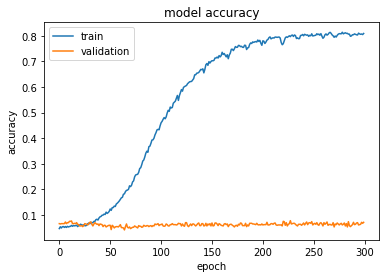

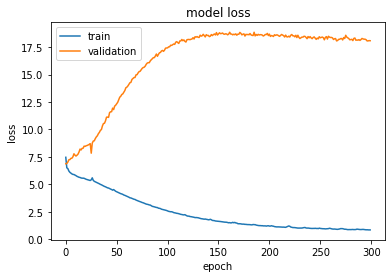

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [37]:
#save model
model.save('/content/drive/MyDrive/ai_poeta/', overwrite=True, include_optimizer=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/ai_poeta/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/ai_poeta/assets


In [38]:
#load our saved model
import keras # we repeat only for loading our saved model case
model = keras.models.load_model('/content/drive/MyDrive/ai_poeta/')

Generate

In [63]:
starting_word = "Heart pain" #Put here some  sequence you want our AI to start from...
words_number = 30 #you can change this number, if you prefer longer or shorter 
#text to be generated
  
for _ in range(words_number):
	token_list = tokenizer.texts_to_sequences([starting_word])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	starting_word += " " + output_word

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [64]:
from collections import Counter

#y = starting_word.split(" ")
    
#print(starting_word.replace(' ', '\n'))

for i in range(0,30,5):
    print(starting_word.split(' ')[i], starting_word.split(' ')[i+1],
          starting_word.split(' ')[i+2], starting_word.split(' ')[i+3],
          starting_word.split(' ')[i+4])

Heart pain with sunlight man
to find his way by
my great betray put in
her heart to be loved
my people in they people
when from they gaze meant
